![Wine and Grapes](images/wine-and-grapes.png)

## Introduction
This notebook contains an example of how to build a custom text-classification model for wines. It contains two approaches:

- Feature Extraction: Use the hidden state of a DistilBERT model as features and train a model on them. The DistilBERT model weights are frozen and not updated. Only the classification head is trained. 
- Fine-tuning: Train DistilBERT's model parameters and the classification head.

The contents of this notebook are heavily influenced by "Chapter 2 - Text Classification" of the excellent book, "Natural Language Processing with Transformers" by Lewis Tunstall, Leandro von Werra and Thomas Wolf.

## Motivation
Chapter 2 of the aforementioned book provides an example of how to develop a text-classification model for emotional sentiment analysis of tweets. The dataset consists of both tweets and labels thereby leading to supervised learning. I wanted to apply the techniques in the chapter to a new dataset to reinforce my own understanding of Hugging Face Transformers and Datasets, experience how capable DistilBERT is as a base model and provide a foundation for performance tuning for efficient deployment. I was curious whether I could create a useful model that was fast, small and used significantly less resources (storage, GPU cycles, GPU memory) than increasingly capable but large decoder models such as Llama 3, GPT4-0, etc.

## Dataset
After exploring a few datasets hosted on Hugging Face, I decided to work with one consisting of [80,000 wine reviews](https://huggingface.co/datasets/GroNLP/ik-nlp-22_winemag). Associated with each review was a country of origin, price, points, province and variety. I wondered whether it would be possible to train a model to predict the grape variety based only on the review. I imagined that the attributes of the grapes would feature strongly in the description so provider the reviewer has a good nose and palate and an equally rich vocabulary, this should be possible. So, let's get started.

## Part 1 - Feature Extraction
DistilBERT (Distilled BERT) is a streamlined version of the popular BERT (Bidirectional Encoder Representations from Transformers) model. It converts input sequences of tokens into numerical representations. Like other transformer-based models, DistilBERT requires text data to be pre-tokenised using an appropriate tokeniser. This can be easily achieved using 🤗 `transformers.AutoTokenizer()`, which automatically selects the optimal tokeniser for a given model, allowing seamless switching between different models with minimal code changes.


After tokenisation, DistilBERT processes the input text through multiple embedding layers. These layers map the original vector space, determined by the tokeniser's vocabulary size, to a smaller and more efficient dimensional space. This enables the model to capture nuanced contextual information from the input text.

The self-attention mechanism in DistilBERT then refines the token weights based on their surrounding context, producing contextual embeddings that capture the intricate relationships between words within the input sequence. By leveraging this contextual understanding, DistilBERT can effectively perform a variety of natural language processing tasks, such as language translation, sentiment analysis and text classification.

Import all the libraries we'll use later in the notebook. It's a personal preference to keep all these together.

In [33]:
from transformers import pipeline, AutoTokenizer, AutoModel, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colormaps
import torch
import random
import numpy as np
from umap.umap_ import UMAP
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from datasets import ClassLabel
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score, f1_score
from huggingface_hub import notebook_login
import pickle

Download the dataset from 🤗 Hugging Face. It's relatively small at only 22.4 MB.

In [34]:
wines = load_dataset("GroNLP/ik-nlp-22_winemag")

Let's take a look at the structure of the dataset.

In [35]:
wines

DatasetDict({
    train: Dataset({
        features: ['index', 'country', 'description', 'points', 'price', 'province', 'variety'],
        num_rows: 70458
    })
    validation: Dataset({
        features: ['index', 'country', 'description', 'points', 'price', 'province', 'variety'],
        num_rows: 5000
    })
    test: Dataset({
        features: ['index', 'country', 'description', 'points', 'price', 'province', 'variety'],
        num_rows: 5000
    })
})

In [36]:
wines["train"].features

{'index': Value(dtype='int64', id=None),
 'country': Value(dtype='string', id=None),
 'description': Value(dtype='string', id=None),
 'points': Value(dtype='int64', id=None),
 'price': Value(dtype='float64', id=None),
 'province': Value(dtype='string', id=None),
 'variety': Value(dtype='string', id=None)}

In [37]:
wines["train"][42]

{'index': 59424,
 'country': 'France',
 'description': "A dense wine, with black fruits that go in one direction, and tannins that go in another. Maybe this is because it's young. There is some good, ripe acidity and blackberry flavors, so in six months, this may well integrate.",
 'points': 85,
 'price': 15.0,
 'province': 'Bordeaux',
 'variety': 'Bordeaux-style Red Blend'}

Three things are immediately apparent.

1. There's no `label` column, so we should change column `variety` to `label` as that's what we want to classify reviews (descriptions) against. Initially I left it as `variety` but during fine-tuning  `trainer.train()` expects the target column to be called label.

2. The `variety` column contains textual descriptions of each grape such as `Bordeaux-style Red Blend`. The general practice appears to be to convert the target column to a `ClassLabel` which replaces the textual values with integer ids representing each class. This make more efficient use of storage and memory.

3. We could of course use other fields in the dataset to improve the classifier such as the country, province etc as certain grapes will almost certainly be most common in certain regions. For now, let's stick to only using the review description.


Let's start by renaming the column name.

In [38]:
wines = wines.rename_column("variety", "label")

In [39]:
wines

DatasetDict({
    train: Dataset({
        features: ['index', 'country', 'description', 'points', 'price', 'province', 'label'],
        num_rows: 70458
    })
    validation: Dataset({
        features: ['index', 'country', 'description', 'points', 'price', 'province', 'label'],
        num_rows: 5000
    })
    test: Dataset({
        features: ['index', 'country', 'description', 'points', 'price', 'province', 'label'],
        num_rows: 5000
    })
})

Next, let's encode all the labels.

In [40]:
wines = wines.class_encode_column("label")

In [41]:
wines["train"].features

{'index': Value(dtype='int64', id=None),
 'country': Value(dtype='string', id=None),
 'description': Value(dtype='string', id=None),
 'points': Value(dtype='int64', id=None),
 'price': Value(dtype='float64', id=None),
 'province': Value(dtype='string', id=None),
 'label': ClassLabel(names=['Barbera', 'Bordeaux-style Red Blend', 'Bordeaux-style White Blend', 'Cabernet Franc', 'Cabernet Sauvignon', 'Champagne Blend', 'Chardonnay', 'Gewürztraminer', 'Glera', 'Grenache', 'Malbec', 'Merlot', 'Nebbiolo', 'Petite Sirah', 'Pinot Grigio', 'Pinot Gris', 'Pinot Noir', 'Portuguese Red', 'Red Blend', 'Rhône-style Red Blend', 'Riesling', 'Rosé', 'Sangiovese', 'Sangiovese Grosso', 'Sauvignon Blanc', 'Sparkling Blend', 'Syrah', 'Tempranillo', 'Tempranillo Blend', 'Viognier', 'White Blend', 'Zinfandel'], id=None)}

Let's see how many distinct class labels there are.

In [42]:
number_wine_classes = wines["train"].features["label"].num_classes
number_wine_classes

32

Let's take a look at the the training data set and perform some basic data exploration. To do this it's more convenient to convert the dataset to a pandas DataFrame.

In [43]:
wines.set_format(type="pandas")
df = wines["train"][:]
df.head(10)

index country  \
0  129857      US   
1  112217      US   
2  114216  France   
3   37808  France   
4   31157      US   
5   85860   Italy   
6   70196      US   
7   88649   Italy   
8   52675      US   
9   69926  France   

                                                                                                                                                                                                                                                                                                                                   description  \
0                                                                                                  Dusty tannins make for a soft texture in this wine that's subtle in dried fruit, Christmas spice, chocolate and clove. It delivers flavor and complexity without attitude, a savory expression of the grape from a relatively cool climate.   
1                                                                                                                       Sweet-tart Maraschino cherry and bitter bramble notes meld in this punchy, primary red wine. Cranberry acidity hits the midpalate with a spine tingling force and lingers through a moderately long finish. Drink now.   
2                                                      A lightly orange-colored rosé that is made by macerating the grapes on the skins for 72 hours. The result is a soft wine, very dry while also showing a rounded character that gives richness. Ripe red fruits and a touch of grapefruit are sustained by a mineral texture. Drink now.   
3                                                                                                              A ripe wine that is almost off dry, this has a ripe cherry character, rich in the mouth and with a full texture. The aftertaste brings out spice and tannins. Bordeaux Clairet lies between rosé and red in color and in taste.   
4  Crisp and very floral, this is a beautiful showcase of Anderson Valley's cool climate and commitment to Alsatian varieties. There's a great depth of flavor here—fig, grapefruit, lime and orange peel—not to mention tremendous minerality. This is a wine that can be sipped all day long or enjoyed with fish, poultry or an onion tart.   
5                                                                                                                    This bright Riserva Merlot offers chewy cherry flavors followed by elegant notes of spice, tar and cola. The mouthfeel is rich and velvety. Pair this ruby-colored wine with duck confit seasoned with ginger and orange.   
6       The nose on this bottling shows just enough of everything to please all sorts of Chardonnay fans: yellow apple flesh, sea salt, a touch of butter and jasmine-laced honeydew aromas. The palate starts soft and then slowly sizzles with acidity, presenting flavors of butter, lemon rinds and key lime. It's a down-the-middle wine.   
7                                                                                                            Crisp and refreshing, this lovely sparkler offers sensations of white wild flowers, green apple, citrus and Bartlett pear. Vibrant acidity balances the creamy, elegantly foaming palate and gives it a dry, invigorating finish.   
8                                                                                This is from a fantastic vineyard site in the Laguna Hills neighborhood of the appellation, and the second vintage of this particular selection from this producer. Generous lemony oak meets toast within a robust body of complex layers and salty caramel.   
9                                                                                                                                                 This 60% Merlot and 40% Cabernet Franc blend is very fruity and fresh, balancing dry tannins and attractive red fruit flavors. It is light, still tight with its structure. Drink from 2016.   

   points  price    province  label  
0      90   44.

Actually, it's quite helpful to see the text associated with labels during the data exploration stage. I suspect that some of the reviews will make reference to the type of grape in the description. This will make the model appear better than it really is. Let's add another column `label_name` and take a closer look. 

In [44]:
def label_int2str(row):
    return wines["train"].features["label"].int2str(row)

df["label_name"] = df["label"].apply(label_int2str)


In [45]:
pd.options.display.max_colwidth = 400
df.head(10)

index country  \
0  129857      US   
1  112217      US   
2  114216  France   
3   37808  France   
4   31157      US   
5   85860   Italy   
6   70196      US   
7   88649   Italy   
8   52675      US   
9   69926  France   

                                                                                                                                                                                                                                                                                                                                   description  \
0                                                                                                  Dusty tannins make for a soft texture in this wine that's subtle in dried fruit, Christmas spice, chocolate and clove. It delivers flavor and complexity without attitude, a savory expression of the grape from a relatively cool climate.   
1                                                                                                                       Sweet-tart Maraschino cherry and bitter bramble notes meld in this punchy, primary red wine. Cranberry acidity hits the midpalate with a spine tingling force and lingers through a moderately long finish. Drink now.   
2                                                      A lightly orange-colored rosé that is made by macerating the grapes on the skins for 72 hours. The result is a soft wine, very dry while also showing a rounded character that gives richness. Ripe red fruits and a touch of grapefruit are sustained by a mineral texture. Drink now.   
3                                                                                                              A ripe wine that is almost off dry, this has a ripe cherry character, rich in the mouth and with a full texture. The aftertaste brings out spice and tannins. Bordeaux Clairet lies between rosé and red in color and in taste.   
4  Crisp and very floral, this is a beautiful showcase of Anderson Valley's cool climate and commitment to Alsatian varieties. There's a great depth of flavor here—fig, grapefruit, lime and orange peel—not to mention tremendous minerality. This is a wine that can be sipped all day long or enjoyed with fish, poultry or an onion tart.   
5                                                                                                                    This bright Riserva Merlot offers chewy cherry flavors followed by elegant notes of spice, tar and cola. The mouthfeel is rich and velvety. Pair this ruby-colored wine with duck confit seasoned with ginger and orange.   
6       The nose on this bottling shows just enough of everything to please all sorts of Chardonnay fans: yellow apple flesh, sea salt, a touch of butter and jasmine-laced honeydew aromas. The palate starts soft and then slowly sizzles with acidity, presenting flavors of butter, lemon rinds and key lime. It's a down-the-middle wine.   
7                                                                                                            Crisp and refreshing, this lovely sparkler offers sensations of white wild flowers, green apple, citrus and Bartlett pear. Vibrant acidity balances the creamy, elegantly foaming palate and gives it a dry, invigorating finish.   
8                                                                                This is from a fantastic vineyard site in the Laguna Hills neighborhood of the appellation, and the second vintage of this particular selection from this producer. Generous lemony oak meets toast within a robust body of complex layers and salty caramel.   
9                                                                                                                                                 This 60% Merlot and 40% Cabernet Franc blend is very fruity and fresh, balancing dry tannins and attractive red fruit flavors. It is light, still tight with its structure. Drink from 2016.   

   points  price    province  label                la

As suspected, several of the reviews/descriptions contain the target labels e.g. row 6 "The nose on this bottling shows just enough of everything to please all sorts of Chardonnay fans ...". Let's revisit this later. A reasonable approach would be to replace any labels that appears in the description with the word "wine". For now let's proceed knowing that our encoder's performance will be affected.

Let's now look at the class distributions in the training data set.

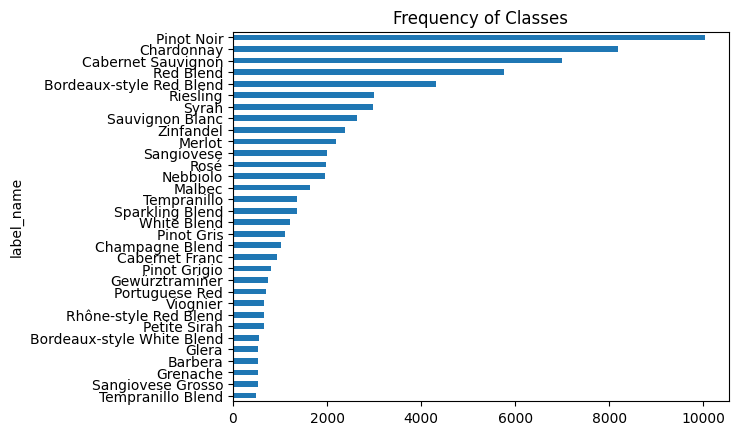

In [46]:
df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

The classes are terribly unbalanced and significantly skewed towards Pinot Noir. I would imagine the number of reviews is related to a particular wine's popularity or maybe the reviwer(s) are biased. Using a skewed training set will affect the models performance and introduce bias. We should revisit this later too. For now, let's proceed cautiously.

let's now take a look at the distribution of the length of each review.

In [47]:
df["words per description"] = df["description"].str.split().apply(len)

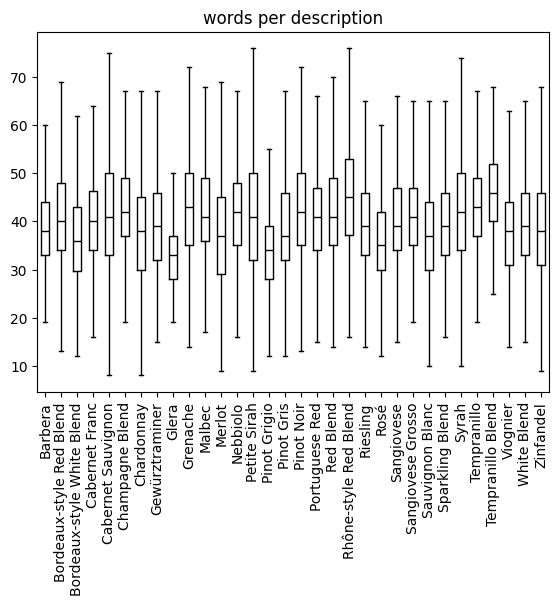

In [48]:
df.boxplot("words per description", by="label_name", grid=False,
          showfliers=False, color="black", rot=90)
plt.suptitle("")
plt.xlabel("")
plt.show()

Most descriptions tend to be around 40-45 words in length with the longest reviews being 80 words.

With some rudimentary exploratory data analysis complete, let's rest the output format as we no longer need to work with DataFrames.

In [49]:
wines.reset_format()

As previously mentioned, let's use a DistilBERT base model and use the corresponding tokeniser. 🤗 `Transformers.Autotokenizer.from_pretrained()` will allow us to easily change the model later without having to update the tokeniser.

In [50]:
model_ckpt = "distilbert-base-uncased"
tokeniser = AutoTokenizer.from_pretrained(model_ckpt)

/home/djh/Development/python/wine-classification/venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Let's tokenise one of the training examples and see what it looks like.

In [51]:
encoded_text = tokeniser(wines["train"][42]["description"])
encoded_text

{'input_ids': [101, 1037, 9742, 4511, 1010, 2007, 2304, 10962, 2008, 2175, 1999, 2028, 3257, 1010, 1998, 9092, 11483, 2015, 2008, 2175, 1999, 2178, 1012, 2672, 2023, 2003, 2138, 2009, 1005, 1055, 2402, 1012, 2045, 2003, 2070, 2204, 1010, 22503, 5648, 3012, 1998, 25935, 26389, 1010, 2061, 1999, 2416, 2706, 1010, 2023, 2089, 2092, 17409, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

Each word or punctuation charter has been converted into one or more tokens. Let's take a closer look at the tokenised text.

In [52]:
tokens = tokeniser.convert_ids_to_tokens(encoded_text.input_ids)
tokens

['[CLS]',
 'a',
 'dense',
 'wine',
 ',',
 'with',
 'black',
 'fruits',
 'that',
 'go',
 'in',
 'one',
 'direction',
 ',',
 'and',
 'tan',
 '##nin',
 '##s',
 'that',
 'go',
 'in',
 'another',
 '.',
 'maybe',
 'this',
 'is',
 'because',
 'it',
 "'",
 's',
 'young',
 '.',
 'there',
 'is',
 'some',
 'good',
 ',',
 'ripe',
 'acid',
 '##ity',
 'and',
 'blackberry',
 'flavors',
 ',',
 'so',
 'in',
 'six',
 'months',
 ',',
 'this',
 'may',
 'well',
 'integrate',
 '.',
 '[SEP]']

There's a few special tokens [CLS] and [SEP] that mark the start and end of a sequence. They mark the start and end of an input sequence respectfully. The tokeniser has also broken down some words into multiple tokens. For example, the word "tannins" is split between three tokens.

In [53]:
tokeniser.convert_tokens_to_string(tokens)

"[CLS] a dense wine, with black fruits that go in one direction, and tannins that go in another. maybe this is because it ' s young. there is some good, ripe acidity and blackberry flavors, so in six months, this may well integrate. [SEP]"

Let's see how large the vocabulary and max context window size is.

In [54]:
tokeniser.vocab_size

30522

In [55]:
tokeniser.model_max_length

512

This is a small context length (window) but should be more than ample for this use case given the maximum review size is about 80 words. Setting `max_length` when the tokeniser is initialised will improve performance and if a future optimisation task.

As we'll need to tokenise all the datasets, let's define a function to process them in batches.

In [56]:
def tokenise(batch):
    return tokeniser(batch["description"], padding=True, truncation=True)

In [57]:
tokenise(wines["train"][:3])

{'input_ids': [[101, 12727, 9092, 11483, 2015, 2191, 2005, 1037, 3730, 14902, 1999, 2023, 4511, 2008, 1005, 1055, 11259, 1999, 9550, 5909, 1010, 4234, 17688, 1010, 7967, 1998, 18856, 21818, 1012, 2009, 18058, 14894, 1998, 11619, 2302, 7729, 1010, 1037, 7842, 14550, 2100, 3670, 1997, 1996, 14722, 2013, 1037, 4659, 4658, 4785, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 4086, 1011, 16985, 2102, 13955, 11624, 5740, 9115, 1998, 8618, 20839, 3468, 3964, 11463, 2094, 1999, 2023, 8595, 2100, 1010, 3078, 2417, 4511, 1012, 13675, 2319, 9766, 5648, 3012, 4978, 1996, 3054, 19636, 2618, 2007, 1037, 8560, 23690, 2486, 1998, 26577, 2015, 2083, 1037, 17844, 2146, 3926, 1012, 4392, 2085, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1037, 8217, 4589, 1011, 6910, 3123, 2008, 2003, 2081, 2011, 19382, 15172, 1996, 16575, 2006, 1996, 21049, 2005, 5824, 2847, 1012, 1996, 2765, 2003, 1037, 3730, 4511, 1010, 2200, 4318, 2096, 2036, 4760, 1037, 8352, 2839, 2008, 3957, 4138, 2791, 1012, 22503, 2417, 1

There are several zeros in the attention mask for the first two tokenised strings. This happens because the tokenised strings are shorter than the third example and so they are padded with zeros.

Let's apply the tokeniser to each of the data splits (test, train, validation)

In [58]:
wines_encoded = wines.map(tokenise, batched=True, batch_size=None)

In [59]:
wines_encoded

DatasetDict({
    train: Dataset({
        features: ['index', 'country', 'description', 'points', 'price', 'province', 'label', 'input_ids', 'attention_mask'],
        num_rows: 70458
    })
    validation: Dataset({
        features: ['index', 'country', 'description', 'points', 'price', 'province', 'label', 'input_ids', 'attention_mask'],
        num_rows: 5000
    })
    test: Dataset({
        features: ['index', 'country', 'description', 'points', 'price', 'province', 'label', 'input_ids', 'attention_mask'],
        num_rows: 5000
    })
})

In [60]:
wines_encoded["train"][42]

{'index': 59424,
 'country': 'France',
 'description': "A dense wine, with black fruits that go in one direction, and tannins that go in another. Maybe this is because it's young. There is some good, ripe acidity and blackberry flavors, so in six months, this may well integrate.",
 'points': 85,
 'price': 15.0,
 'province': 'Bordeaux',
 'label': 1,
 'input_ids': [101,
  1037,
  9742,
  4511,
  1010,
  2007,
  2304,
  10962,
  2008,
  2175,
  1999,
  2028,
  3257,
  1010,
  1998,
  9092,
  11483,
  2015,
  2008,
  2175,
  1999,
  2178,
  1012,
  2672,
  2023,
  2003,
  2138,
  2009,
  1005,
  1055,
  2402,
  1012,
  2045,
  2003,
  2070,
  2204,
  1010,
  22503,
  5648,
  3012,
  1998,
  25935,
  26389,
  1010,
  2061,
  1999,
  2416,
  2706,
  1010,
  2023,
  2089,
  2092,
  17409,
  1012,
  102,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  

We can see there's now a new column "input_ids" that contains the tokenised values from column "description".

We are now going to attach a text-classification head to the transformer body and use the hidden states as features for the classifier. The hidden states for each embedded and encode token are a result of passing through stages:

- Token encoding
- Token embedding
- Encoder Stack

In [64]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

Let's start with a single example taken from the training set. We need the tokenised inputs to be returned a `pytorch` tensors.

In [68]:
inputs = tokeniser(wines_encoded["train"][42]["description"], return_tensors="pt")
print(f"Input tensor shape: {inputs['input_ids'].size()}")

Input tensor shape: torch.Size([1, 55])


In [66]:
inputs

{'input_ids': tensor([[  101,  1037,  9742,  4511,  1010,  2007,  2304, 10962,  2008,  2175,
          1999,  2028,  3257,  1010,  1998,  9092, 11483,  2015,  2008,  2175,
          1999,  2178,  1012,  2672,  2023,  2003,  2138,  2009,  1005,  1055,
          2402,  1012,  2045,  2003,  2070,  2204,  1010, 22503,  5648,  3012,
          1998, 25935, 26389,  1010,  2061,  1999,  2416,  2706,  1010,  2023,
          2089,  2092, 17409,  1012,   102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1]])}

In [63]:
inputs = {k:v.to(device) for k,v in inputs.items()}
with torch.no_grad():
    outputs = model(**inputs)
print(outputs)

BaseModelOutput(last_hidden_state=tensor([[[-0.3252, -0.3477,  0.2937,  ..., -0.2464,  0.2563,  0.1409],
         [-0.3973,  0.0780,  0.2272,  ..., -0.1148,  0.3837,  0.2052],
         [ 0.1159,  0.0597,  0.3262,  ..., -0.0842,  0.0895, -0.2180],
         ...,
         [ 0.1073, -0.0735,  0.3914,  ..., -0.2878, -0.0366, -0.2832],
         [-0.1659, -0.5942,  0.0490,  ...,  0.3200,  0.1373, -0.4893],
         [-0.4971, -0.4010,  0.6147,  ..., -0.2269,  0.2229, -0.3619]]],
       device='cuda:0'), hidden_states=None, attentions=None)


In [69]:
outputs.last_hidden_state.size()

torch.Size([1, 55, 768])

DistilBERT hidden state is a vector/tensor with 768 dimensions (dense dimensional space) for __each__ of the 55 input tokens in the single review description. We'll need to repeat these steps for each input to the model so let's create a function to do process inputs in batches.

In [73]:
def extract_hidden_states(batch):
    # Place model inputs on the GPU
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokeniser.model_input_names}
    # Extract last hidden states
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    # Return vector for [CLS] token
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

We don't have to tokenise all the data again, we just need to convert the input_ids into the `pytorch` tensor format.

In [74]:
wines_encoded.set_format("torch",
                        columns=["input_ids", "attention_mask", "label"])

Now calculate the hidden states for all train, validation and test data. This performs a forward pass through DistilBERT for all our data so it may take a few minutes.

In [75]:
wines_hidden = wines_encoded.map(extract_hidden_states, batched=True)

Map:   0%|          | 0/70458 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

In [76]:
wines_hidden["train"].column_names

['index',
 'country',
 'description',
 'points',
 'price',
 'province',
 'label',
 'input_ids',
 'attention_mask',
 'hidden_state']

Now that we have access to the hidden states for the dataset, it's time to train a basic classifier model. We are only looking to baseline performance so let's start with a simple model that's fast to train: LogisticRegression.

In [77]:
X_train = np.array(wines_hidden["train"]["hidden_state"])
X_valid = np.array(wines_hidden["validation"]["hidden_state"])
y_train = np.array(wines_hidden["train"]["label"])
y_valid = np.array(wines_hidden["validation"]["label"])
X_train.shape, X_valid.shape

((70458, 768), (5000, 768))

We have approximately seventy-thousand training data point and five-thousand validation data points.

A useful technique to visually explore data classification tasks is to map the data to lower dimensional space and look for patterns. For example, are the dataset well separated or do they overlap in lower dimensional space. We'll use Uniform Manifold Approximation and Projection (UMAP) to do this. We're going from 768 dimension to 2 so results may vary.

In [78]:
X_scaled = MinMaxScaler().fit_transform(X_train)
# Initialize and fit UMAP
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)
# Create a DataFrame of 2D embeddings
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train
df_emb.head()

X         Y  label
0  6.185306 -0.950673     11
1  5.109217  2.634994     16
2  4.726616  2.603206      5
3  4.022514 -2.327261      1
4  7.761482  0.835212     15

Let's see what this looks like. To do this we'll create 32 hex-bin plots, one for each variety of wine. A scatter plot would also work but the the hex-bin plot conveniently provides the benefit of a bin-plot in two dimensions. It smooths out the data by grouping data into hexagonal bins.

In [79]:
cmaps = random.sample(list(colormaps), k=number_wine_classes)
print(cmaps)

['Reds_r', 'Set1_r', 'inferno_r', 'gist_yarg_r', 'hot_r', 'binary', 'flag_r', 'magma', 'afmhot_r', 'gist_yarg', 'plasma', 'plasma_r', 'inferno', 'twilight_r', 'Blues_r', 'PRGn_r', 'cividis', 'CMRmap_r', 'Set3', 'turbo', 'YlOrRd', 'Oranges', 'RdYlGn', 'gist_heat_r', 'gist_gray_r', 'prism', 'spring', 'Spectral', 'gnuplot2_r', 'RdYlGn_r', 'winter', 'BuPu_r']


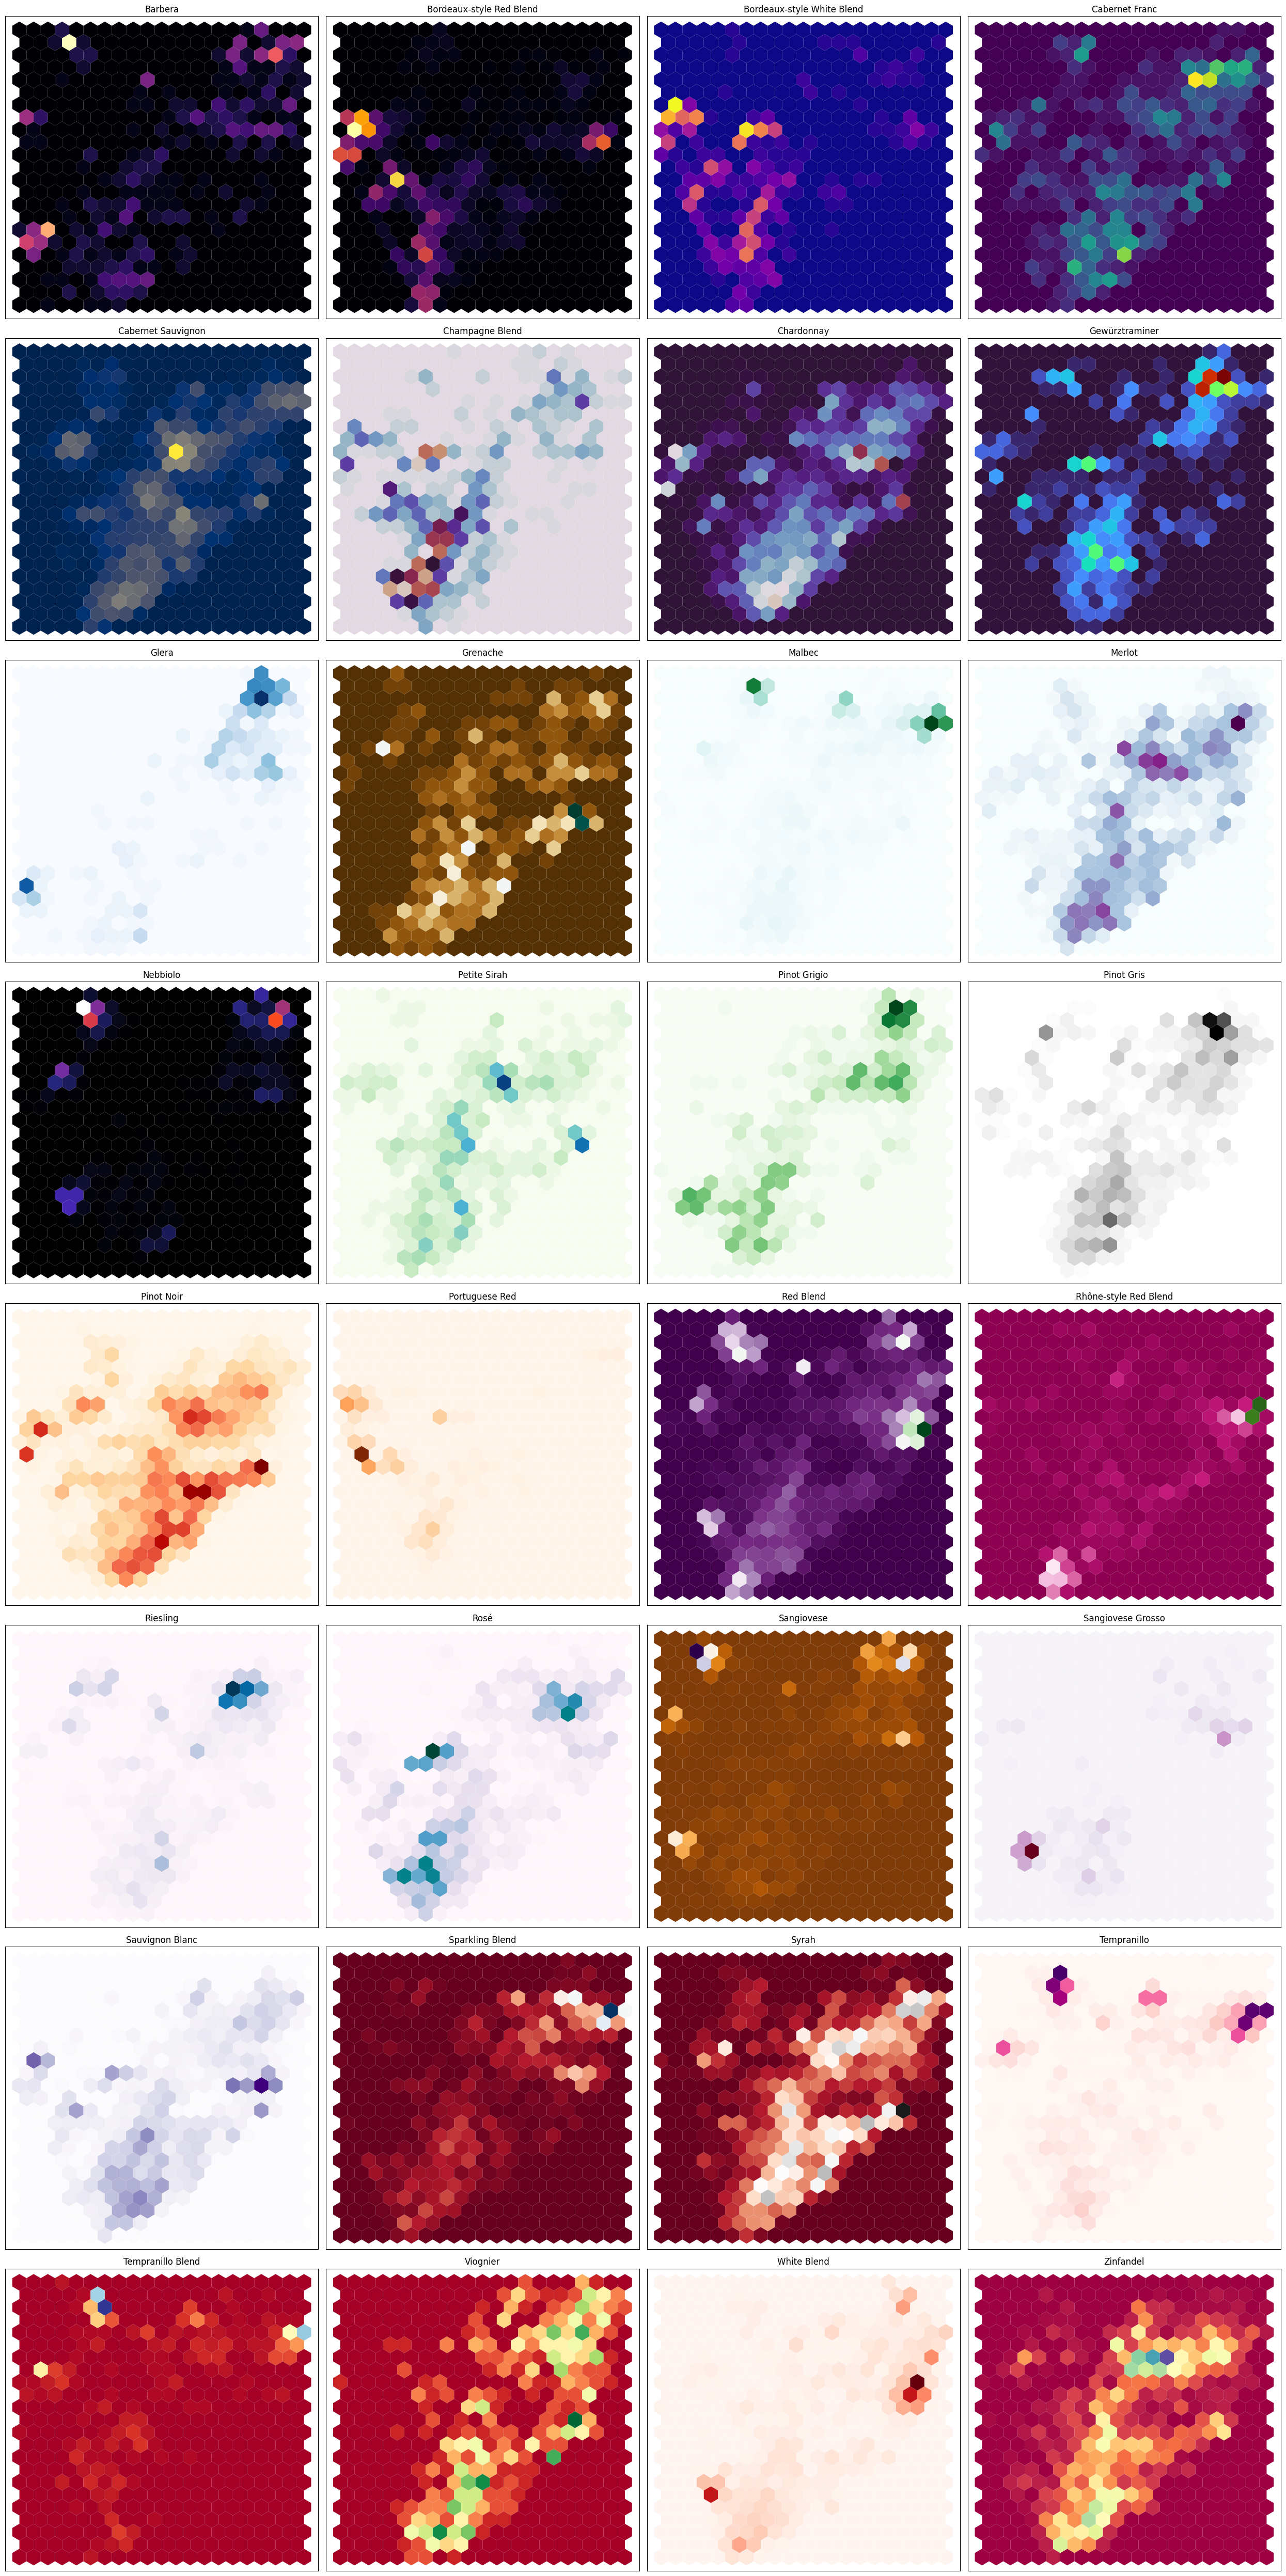

In [81]:
fig, axes = plt.subplots(8, 4, figsize=(25,50))
axes = axes.flatten()
cmaps = list(colormaps)[:number_wine_classes]
labels = wines["train"].features["label"].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap,
                   gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])

plt.tight_layout()
plt.show()

There's a large number of classes and a limited number of useful colour maps. I find hex-bin plots with a light coloured background most easy to process. For example, if we look at Rose and a Riesling, the hex-plots are completely different. This strongly suggests that a model should be able to easy discriminate between then. Let's find out but training a LogisticRegression model.

`scikit-learn` doesn't natively use the GPU. There are a few approaches to adapting it to do so. I experimented with CUDA but ran into some dependency issues with my environment. It only take a few minutes to train on my twenty-core CPU so for now, I'll use the CPU.

In [82]:
lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)

0.5838

This is a low score but it's a useful baseline to build on both for other model such as Stage Vector Machine (SVM), Random Forest and of course hyper-parameter tuning of any model we choose. Optimising a model using the hidden state isn't going to be our main focus, so we'll leave it there for today.

This looks little better than random chance but as we saw earlier the distrubution is skewed. Let's see how much better than random chance it is.

In [86]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)

0.14

This is much better than chance so our baseline model isn't too bad after all.

Let's save this to disk to avoid recomputing the model in the future.

In [83]:
with open('lr_clf_model.pkl', 'wb') as f:
     pickle.dump(lr_clf, f)

In [85]:
# Uncomment if you wish to load the previous model and avoid retraining the LogisticRegression model.
# with open('lr_clf_model.pkl', 'rb') as f:
#    lr_clf = pickle.load(f)
# lr_clf.score(X_valid, y_valid)

Let's now take a look at the relationship between the true (y-axis) and predicted (x-axis) classes from the model. Ideally, the normalised matrix should show 1.0 along the diagonal and 0.0 everywhere else. Low score on the diagonal or higher scores off the diagonal suggest the model will confuse the classes on the respective rows and columns.

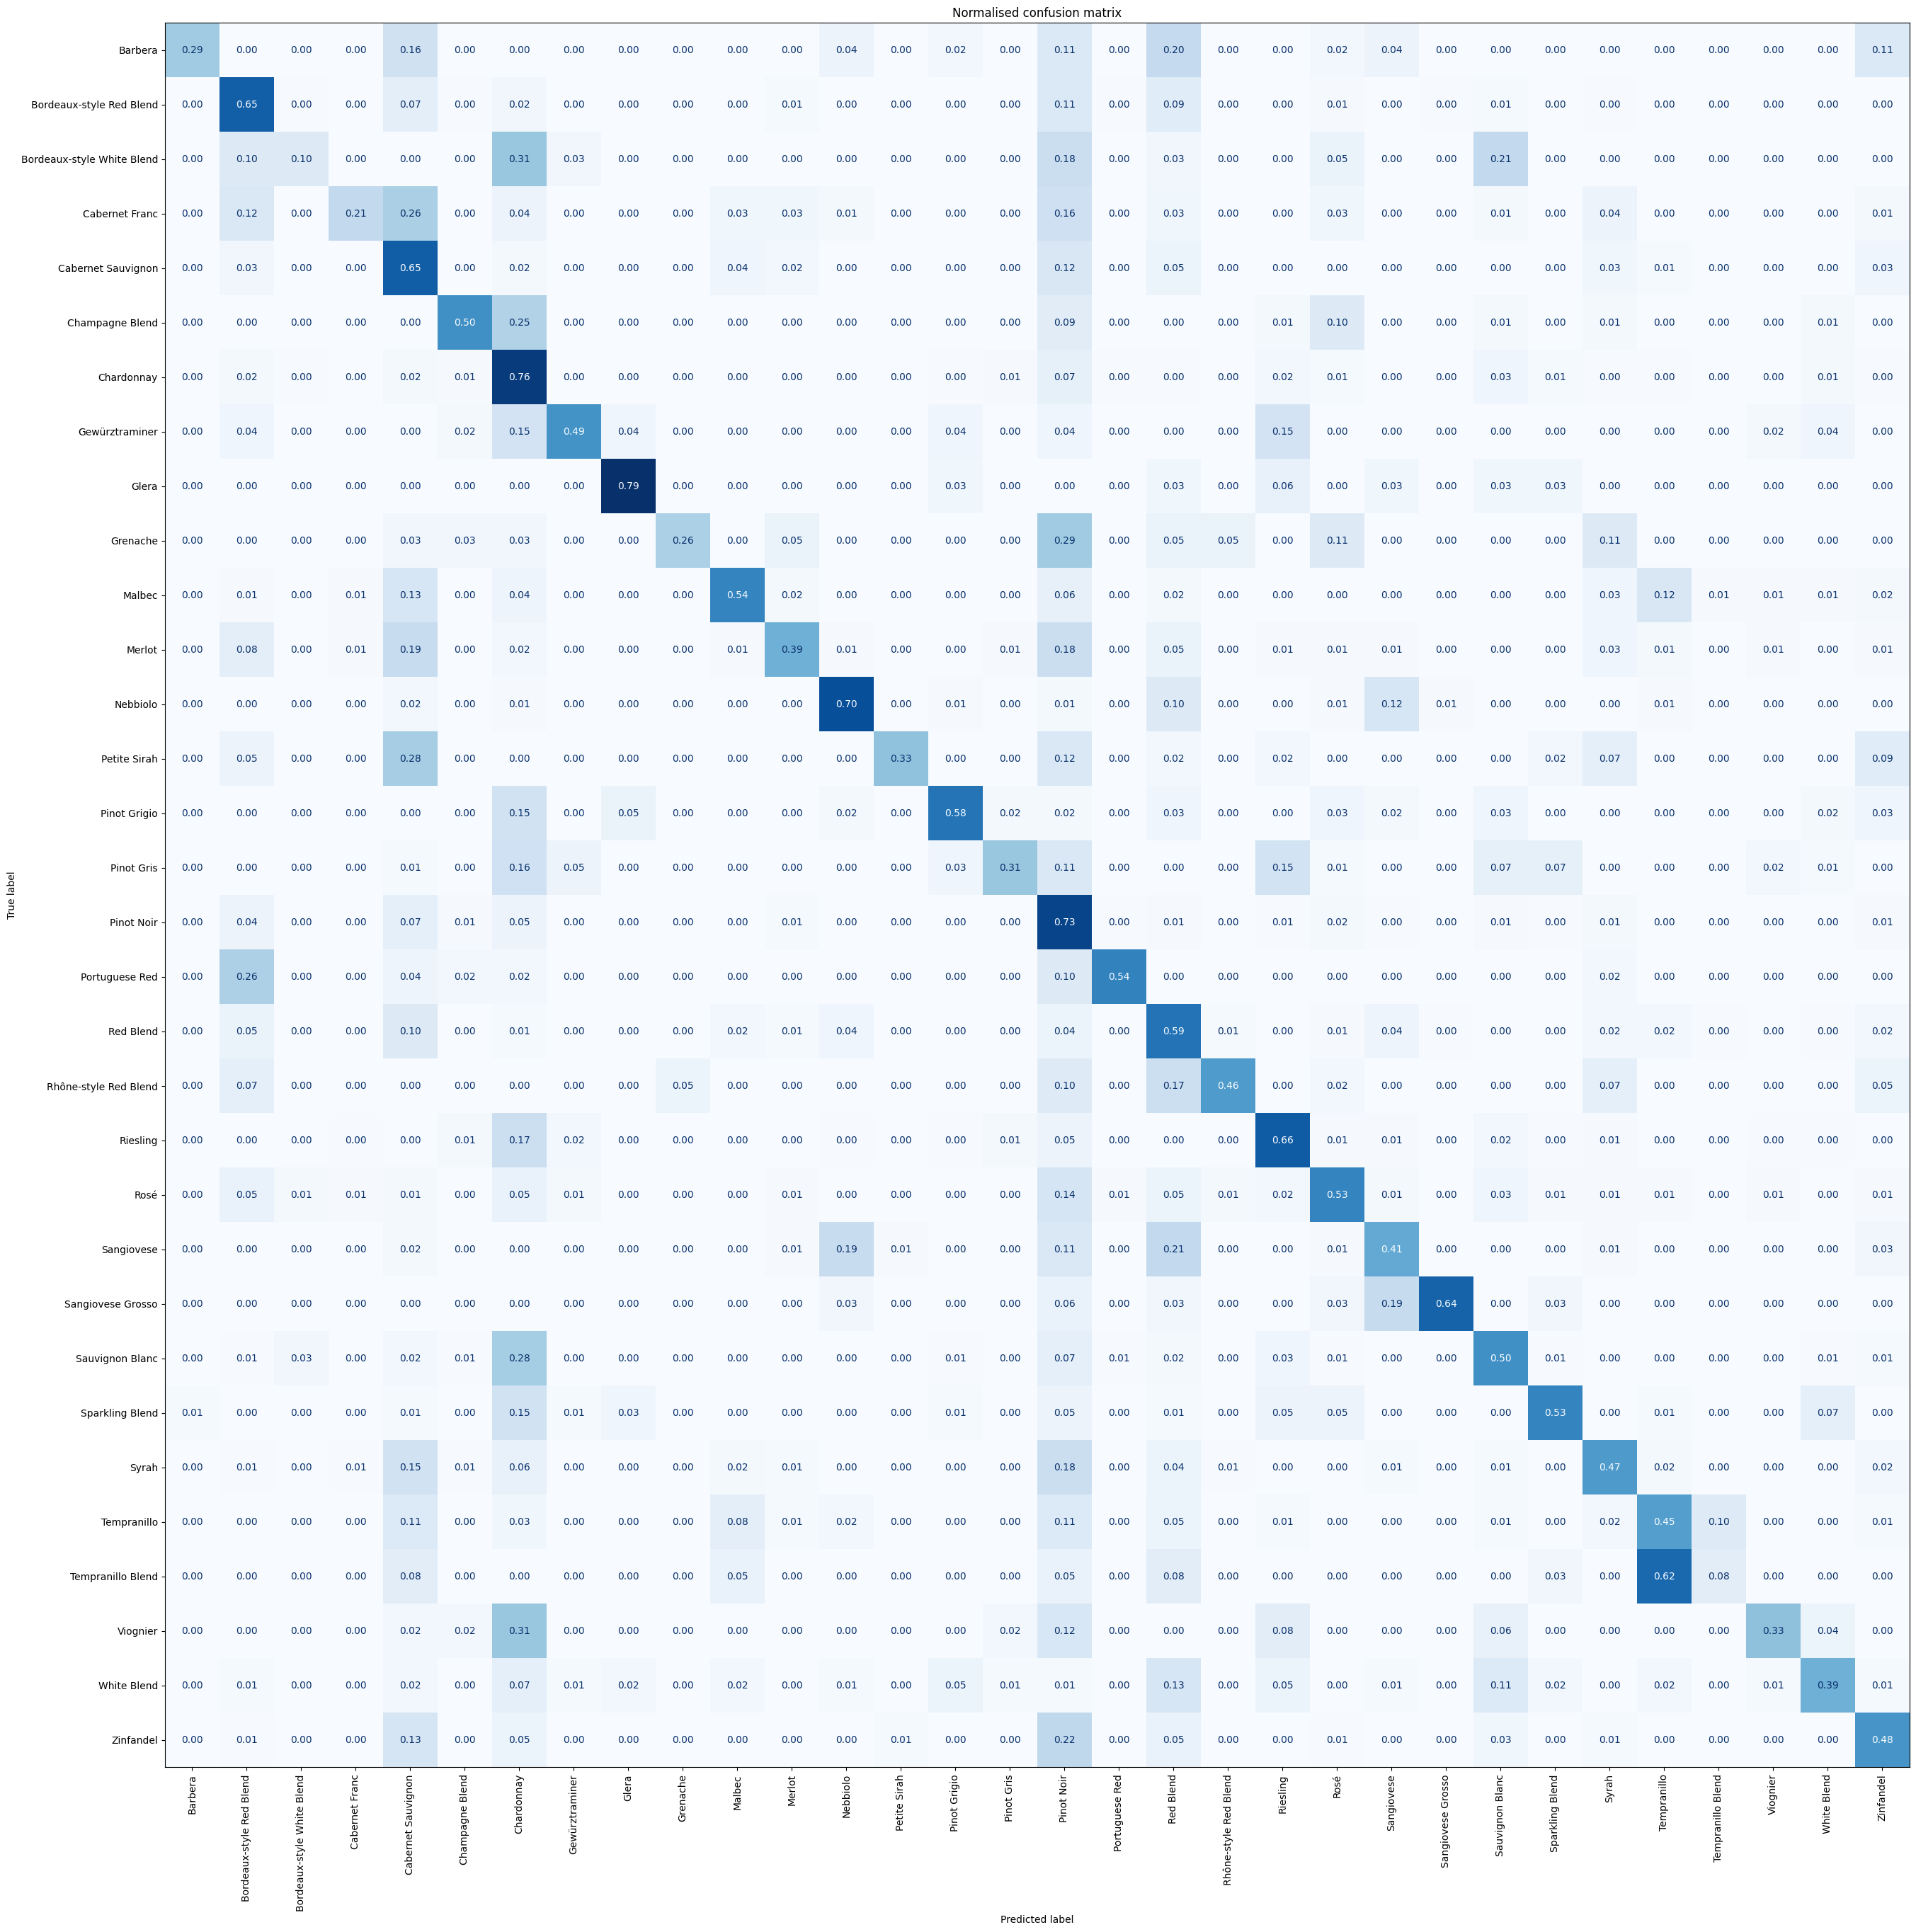

In [88]:
def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(32, 32))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False, xticks_rotation='vertical')
    plt.title("Normalised confusion matrix")
    plt.show()

y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)

There's definitely a few varieties of grape that the model will struggle with. For example, the predicted (x-axis) class of chardonnay is often associated with five or six varieties of grape including viognier , sauvignon blanc, riesling, two varieties of pinot, champagne and a bordeaux-style white blend. We'll come back to the confusion matrix later and see if fine-tuning a model improves matters.

Let's now fine-tune our model. Instead of using the hidden state as fixed features we'll train them.

## Part 2 - Fine Tuning
Instead of just training a classification head on the hidden states of the DistilBERT, we will not unfreeze all the model parameters. This will require significantly more computation that before. Thankfully, the 🤗 `Transformers.AutoModelForSequenceClassification()` and 🤗 `Transformers.Trainer()` provide easy access to a GPU.

In [89]:
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, num_labels=number_wine_classes)
         .to(device))

/home/djh/Development/python/wine-classification/venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


This warning message is expected as we haven't learned the values for the classification head or fine-tuned the parameters of the transformer body yet.

At each training stage (epoch) we'll compute performance metrics for the model in training. We'll use an f1 score and an accuracy score.

- F1: It's the harmonic mean of precision and recall
- Accuracy: measured the ration of true predictions vs total predictions.

In [90]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

We'll update the fine-tuned model to 🤗 Hugging Face so create an access token and use it to authenticate. 

In [91]:
notebook_login()

In [93]:
batch_size = 64
logging_steps = len(wines_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-wine"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=3,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=True,
                                  log_level="error")

Depending on how many epochs you choose and how many GPUs cores you have then could take anywhere from a few minutes to a over an hour. Now would be a great time to get a coffee  ☕️.

In [95]:
trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=wines_encoded["train"],
                  eval_dataset=wines_encoded["validation"],
                  tokenizer=tokeniser)
trainer.train()

TrainOutput(global_step=3303, training_loss=1.1861138677293879, metrics={'train_runtime': 1309.3555, 'train_samples_per_second': 161.434, 'train_steps_per_second': 2.523, 'total_flos': 1.0615113239125248e+16, 'train_loss': 1.1861138677293879, 'epoch': 3.0})

In [96]:
preds_output = trainer.predict(wines_encoded["validation"])

In [97]:
preds_output.metrics

{'test_loss': 0.9082055687904358,
 'test_accuracy': 0.7314,
 'test_f1': 0.7221539599266503,
 'test_runtime': 7.3506,
 'test_samples_per_second': 680.214,
 'test_steps_per_second': 10.747}

If we compare the accuracy of the fine-tuned model (0.73) with the score/mean accuracy of dummy_clf (0.14) this model is significantly better and a notable improvement on training just the classification (0.58). A few additional epochs of training will almost certainly improve this further.

Let's take a look at the normalised confusion matrix again and see how it's improved. Have we been able to reduce the confusion that we saw earlier with Chardonnay?

In [98]:
y_preds = np.argmax(preds_output.predictions, axis=1)

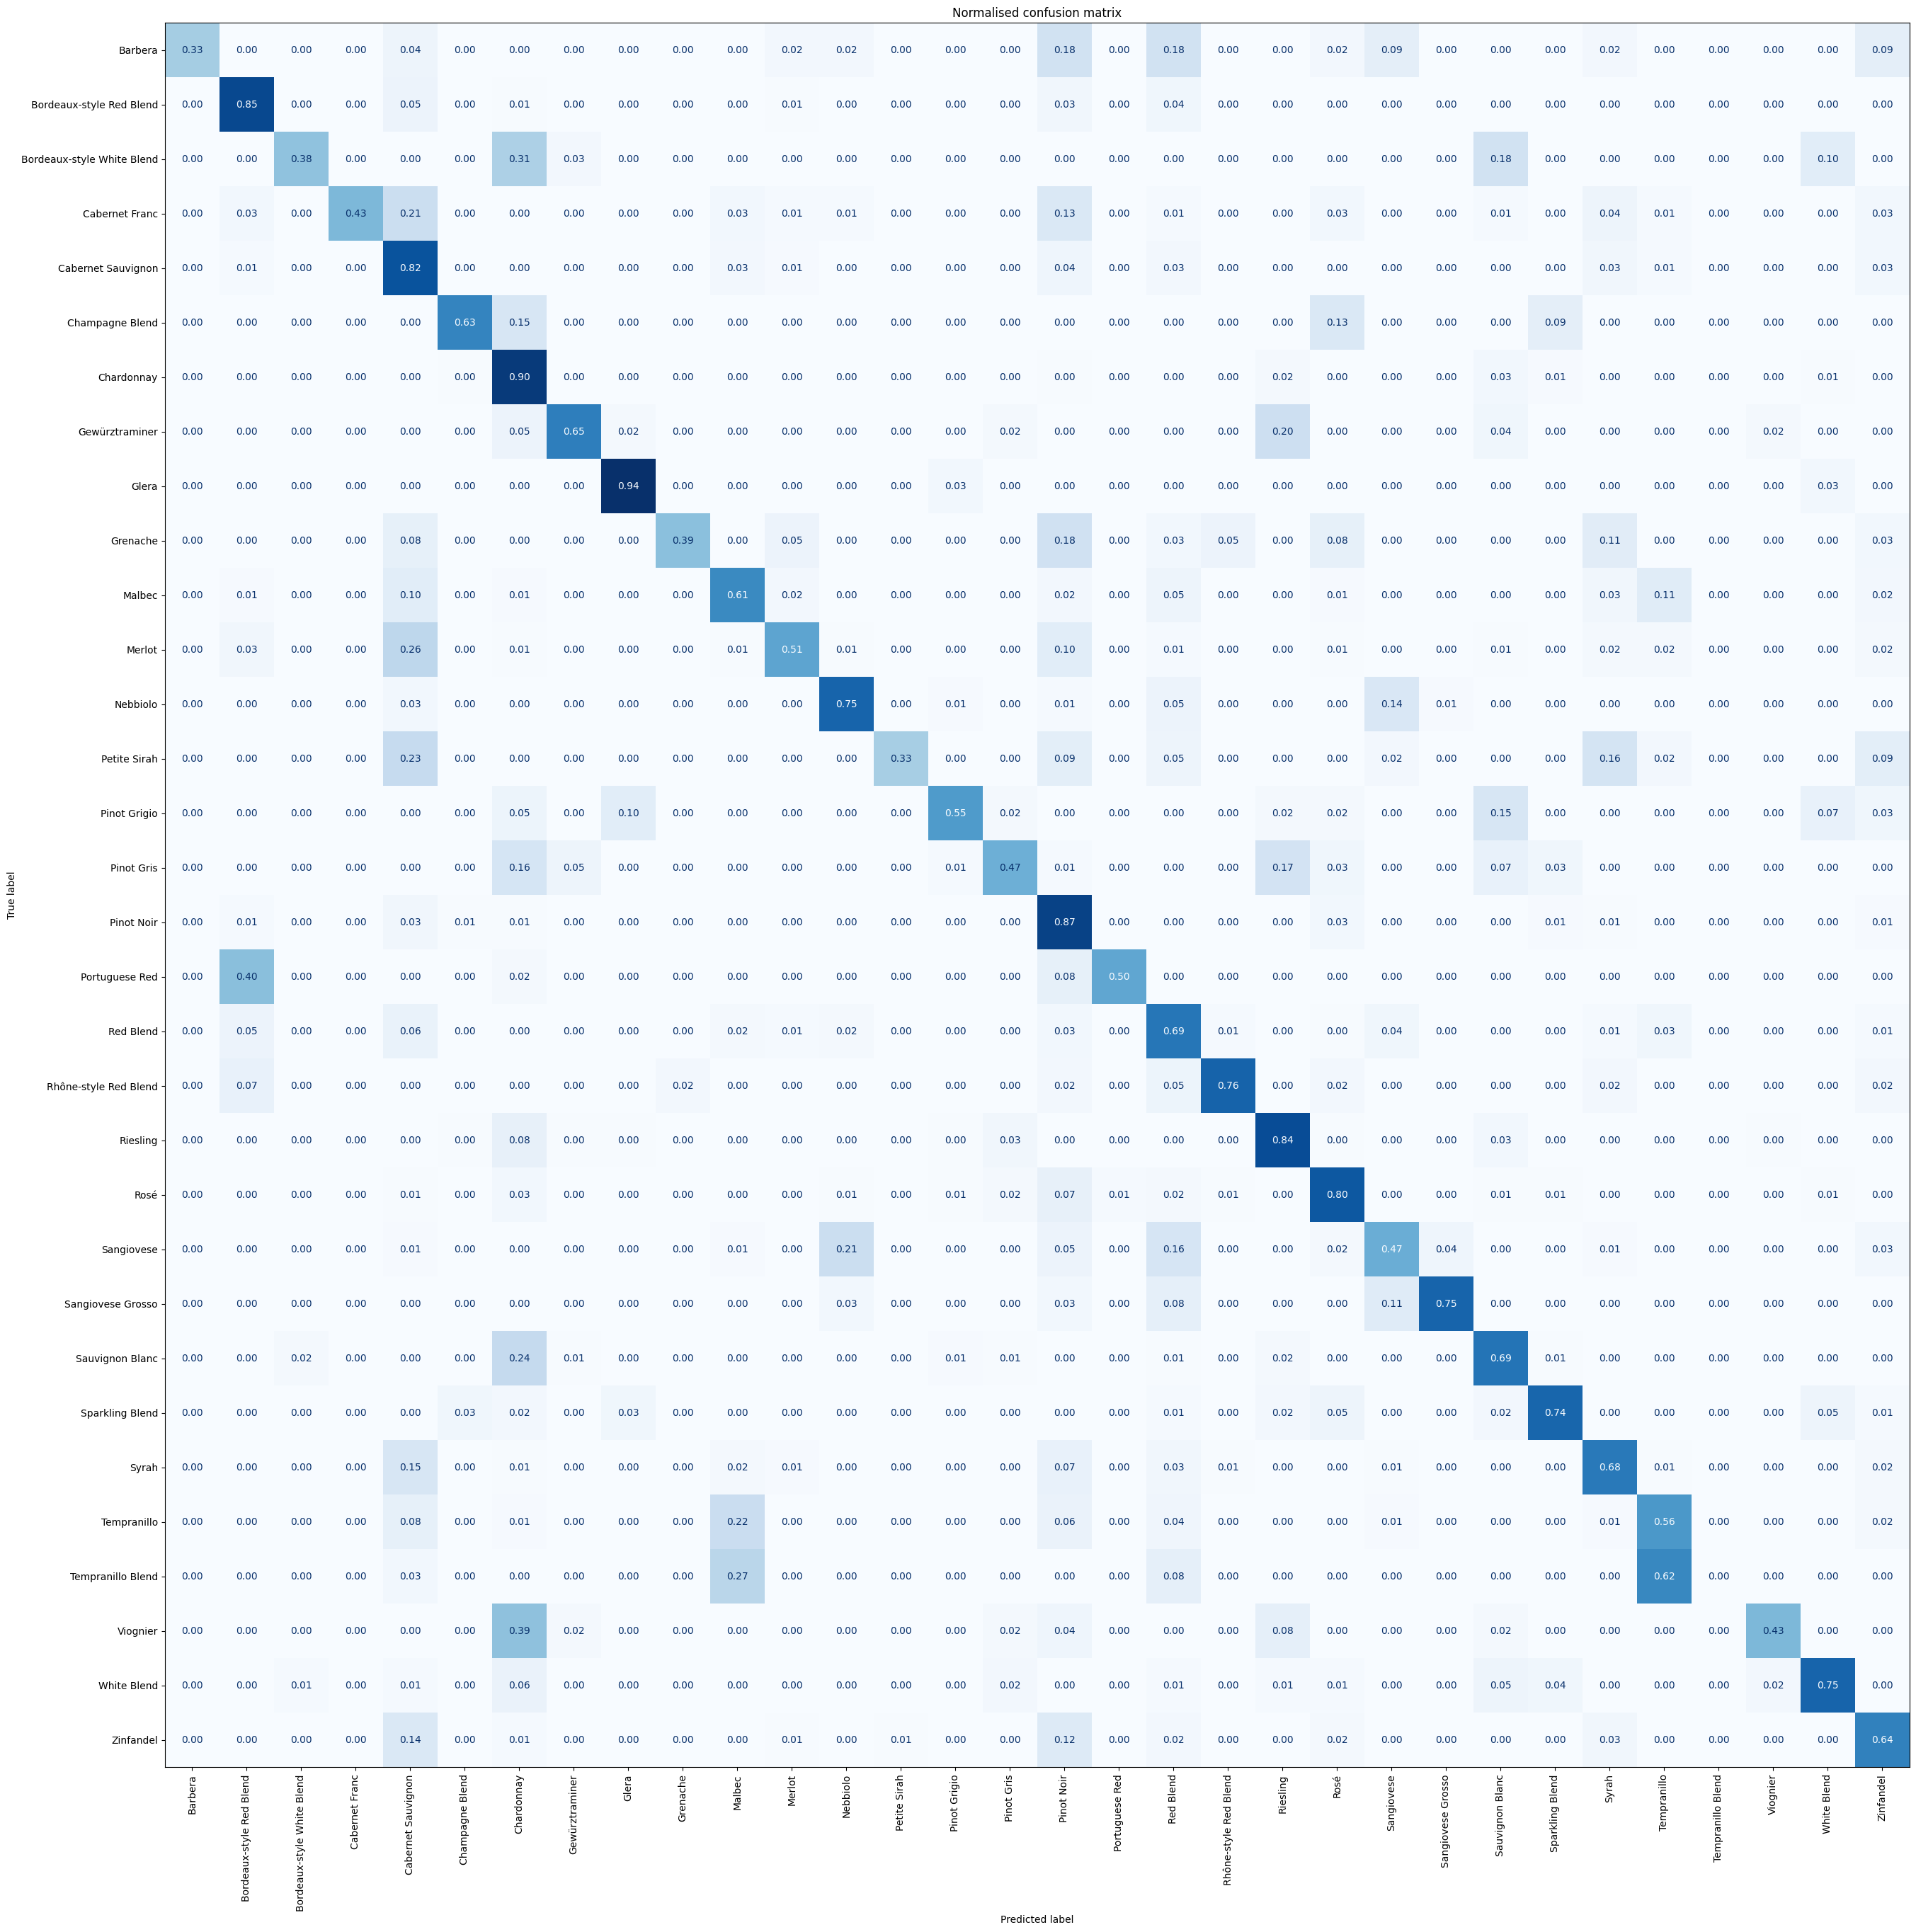

In [117]:
plot_confusion_matrix(y_preds, y_valid, labels)

We've improved confusion between Chardonnay in many ways. The score on the diagonal has incresed from 0.79 to 0.90. We've also reduced the off-diamonal score for almost every cell, with most now being less than or equal to 0.05. There's still some confusion with viognier, sauvignon blanc and Bordeaux style-white, but overall this is still a positive result. 

More broadly, there's been a reduction in confusion across all classes as evidences by reduced colour (lower scores). One column that particular stands out is pinot noir. The confusion matrix from the simple classification matrix showed that the model frequently predicts other labels. This is evidence by several dark cells in across small almost all varieties. While it hasn't been eliminated completely, it is significantly improved. Remember, pinot grigio was the most common class in the biased training set. This adds weight to going back to the data preparation stage and removing or at least reducing the bias to more acceptable levels. 

Let's take a closer look at the validation data that'd contributed the most to the error/loss. This will also guide us during the next revision of the data preparation.

In [102]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    # Place all input tensors on the same device as the model
    inputs = {k:v.to(device) for k,v in batch.items() 
              if k in tokeniser.model_input_names}

    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["label"].to(device), 
                             reduction="none")

    # Place outputs on CPU for compatibility with other dataset columns   
    return {"loss": loss.cpu().numpy(), 
            "predicted_label": pred_label.cpu().numpy()}

In [103]:
wines_encoded.set_format("torch", 
                            columns=["input_ids", "attention_mask", "label"])
# Compute loss values
wines_encoded["validation"] = wines_encoded["validation"].map(
    forward_pass_with_label, batched=True, batch_size=16)

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

In [104]:
wines_encoded.set_format("pandas")
cols = ["description", "label", "predicted_label", "loss"]
df_test = wines_encoded["validation"][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = (df_test["predicted_label"]
                              .apply(label_int2str))

In [105]:
#hide_output
df_test.sort_values("loss", ascending=False).head(10)

description  \
4939       There are soft grapefruit-peach aromas and flavors, tart lime notes and a medium body here. It's not complex, but it's not supposed to be. It has no bad marks at all, and even a little length to show. A good bar pour or gallery opener.   
3218                                                                            Somewhat severe with a stalky fruit character that shows tannins as much as black currant fruits. Spice and a hard edge suggest a wine that is never going to be ripe.   
3530                                                        Solid and tannic with a stalky character both from young fruit and acidity. There is structure, black currant fruits and dense, dry tannins. The wine needs to age for at least 3–4 years.   
3151                                                                                                                                                          This is a heavy, soft, jammy wine that's sweet in raspberry- and strawberry-jam flavors.   
3547  A wine that is structured and dominated at this stage by its tannins. The potential is there, showing in the rich, supporting fruit and berry flavors that come through as the wine opens up. Drink this wine with its good potential from 2017.   
492                                                                                                                           This medium-bodied wine has modest fruit and herb aromas and similarly subdued flavors. It is clean and straightforward.   
2614                                                       Good for its apricot, vanilla and buttercream flavors, but really lacks the sweet richness that an expensive dessert wine needs. It falls apart mid-palate, and turns watery on the finish.   
1726                                                                                                                     Reserve it may be, but it is a thin wine nonetheless, with hard, green flavors and a stemmy, tannic finish. —P.G.  Sangiovese   
2492                                                                                                  This dull, rustic wine offers earth and anise flavors around a core of soft cherry fruit. Light bodied, its acidity is moderate and unobtrusive.   
527                                                                                                    With some richness, this is a drink-now rosé. The initial fresh fruit has diminished, leaving a rounded, caramel-flavored wine without acidity.   

                         label           predicted_label      loss  
4939  Bordeaux-style Red Blend           Sauvignon Blanc  8.205002  
3218     Rhône-style Red Blend  Bordeaux-style Red Blend  7.876331  
3530     Rhône-style Red Blend  Bordeaux-style Red Blend  7.657576  
3151              Pinot Grigio                 Zinfandel  7.519986  
3547     Rhône-style Red Blend  Bordeaux-style Red Blend  7.254154  
492                White Blend        Cabernet Sauvignon  7.250109  
2614                  Riesling                Chardonnay  7.111666  
1726                     Syrah                Sangiovese  6.933029  
2492                   Barbera                Pinot Noir  6.899375  
527      Rhône-style Red Blend                      Rosé  6.876498

The model seems to generating large losses when the true label is Bordeaux-style Red Blend and the predicted label is Sauvignon Blanc. A quick Google search shows that "grapefruit-peach aromas and flavors, tart lime notes" is a common description for a Sauvignon Blanc so maybe this data point is mislabelled? If we look at the confusion matrix, it suggests that "in general" the model does a good job of predicting Sauvignon Blanc suggesting what we are seeing is a few poor data points.

Let's not now at the validation data with the lowest loss/error.

In [106]:
#hide_output
df_test.sort_values("loss", ascending=True).head(10)

description  \
900                                                                                                                                                                                  Here's a fancy Pinot Noir from a great appellation. With a silky texture and modest alcohol, it shows a ripe balance rare in California. Impresses for its array of cherries, raspberries, cola and sweet sandalwood. Drink now.   
4187                                                                                                                                                                Pure fruit flavors of cranberry and raspberry, tart and forward, introduce this light and approachable Pinot. Elegant and stylish, without much staying power, it's a good choice for drinking now while your heartier Pinots rest in the cellar.   
3491                                                                                                          A streak of bright acidity cuts through the ripe red cherry, currant and cola flavors of this full-bodied, young Pinot Noir. It's aggressive and immature now, with the oak unintegrated with the primary fruit, but has a great future. Give it a minimum of six years in the cellar to knit together.   
4035                                                                                                   There's a style to this Pinot that takes some understanding to appreciate. Its cranberry, pomegranate and rhubarb flavors are complex, highlighted by brisk acidity and minerals. The result is an elusive wine, low in earthy elements and immensely satisfying. This is one for the cellar. Best after 2019.   
3129                                                                                                                                                                                                                                                                             Soft and direct, this Pinot Noir offers easy flavors of cherries, currants, cola and spice, wrapped into a silky texture. Drink now.   
2862                                                                                                                                                                                                                      This is a fresh, lively Pinot Noir for drinking now. It's elegantly silky and dry, with crisp acids and pure flavors of cherries, cola, spices and oak. A touch of oak adds smoky richness.   
2697                                            This fresh, supple Pinot comes from a cool Russian River Valley site overlapping the Sonoma Coast AVA. Jenkins sits above the fog line and is rich in Goldridge soils. The wine is lightly mushroomy in earth, and a keen streak of exotic spiciness kicks in convincingly on the finish, after intense and complicated layers of red cherry, raspberry and lavender.   
686                                                                                                              This is the richest and most rewarding of the winery's 2012 range of Pinot Noirs. It's classically dry and silky, with brisk acidity and delicious raspberry jam and cherry pie flavors that have the earthiness of pomegranates and persimmons. It's fine to drink now and over the next six years.   
268   This Pinot seems to float weightlessly on the palate, yet the flavors sink in instantly and dazzle. Suggestions of raspberries and red cherries come spiced in white pepper and cinnamon, with richer levels of Dr. Pepper cola, mocha and red licorice, all highlighted with the most perfect acidity. It's easy to fall in love with this wine and drink it now, but it can develop interesting complexiti...   
471                                                                                    This vineyard has been source to wildly variable Pinot Noirs, but Garnet, has succeeded in wresting a fine Pinot Noir. It shows the dry silkiness and acidity you want from a coastal Pinot, with elaborate, oak-influenc

Two things are immediately apparent. Firstly, all the data points are Pinot Noir. This is the most common variety in the training set and therefore the model has learned a lot about the properties of Pinot Noir. Secondly and probably more significantly, the grape variety is mentioned in the review/description. This gives the model an unfair advantage so it's unsurprising that the loss is so low.

Let's save the model and data to HuggingFace to avoid training it from scratch in the future.

In [107]:
trainer.push_to_hub(commit_message="Increased the number of training epochs. Accuracty and F1 score would benefit from yet further training.")

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/danieljhand/distilbert-base-uncased-finetuned-wine/commit/a29c2e4475712c4ac632071562812d8a5a1905ac', commit_message='Increased the number of training epochs. Accuracty and F1 score would benefit from yet further training.', commit_description='', oid='a29c2e4475712c4ac632071562812d8a5a1905ac', pr_url=None, pr_revision=None, pr_num=None)

let's now reinstatiate the the model from 🤗 Hugging Face.

In [108]:
model_id = "danieljhand/distilbert-base-uncased-finetuned-wine"
classifier = pipeline("text-classification", model=model_id)

/home/djh/Development/python/wine-classification/venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Let's get a few random reviews from https://www.vivino.com and see how it does:

- https://www.vivino.com/users/charlie.gi/reviews/224133697
- https://www.vivino.com/users/nicole-zaj/reviews/304480457
- https://www.vivino.com/users/becca.gom/reviews/112948301

In [111]:
wine_review = ["Cigar nose with tickly achiote spice. In the glass, the tobacco is plentiful but without smoke. Rhubarb hangs out with cherry cider and the mellowest cinnamon to be found.", "grapefruit heavy, green apple, pineapple, peach notes. very crispy and refreshing", "Nose is earthy cassis and spice. Flavor is big and rich, cassis and fresh dark cherry. Good balance and mod length to a smooth tannin finish."]
preds = classifier(wine_review, return_all_scores=True)

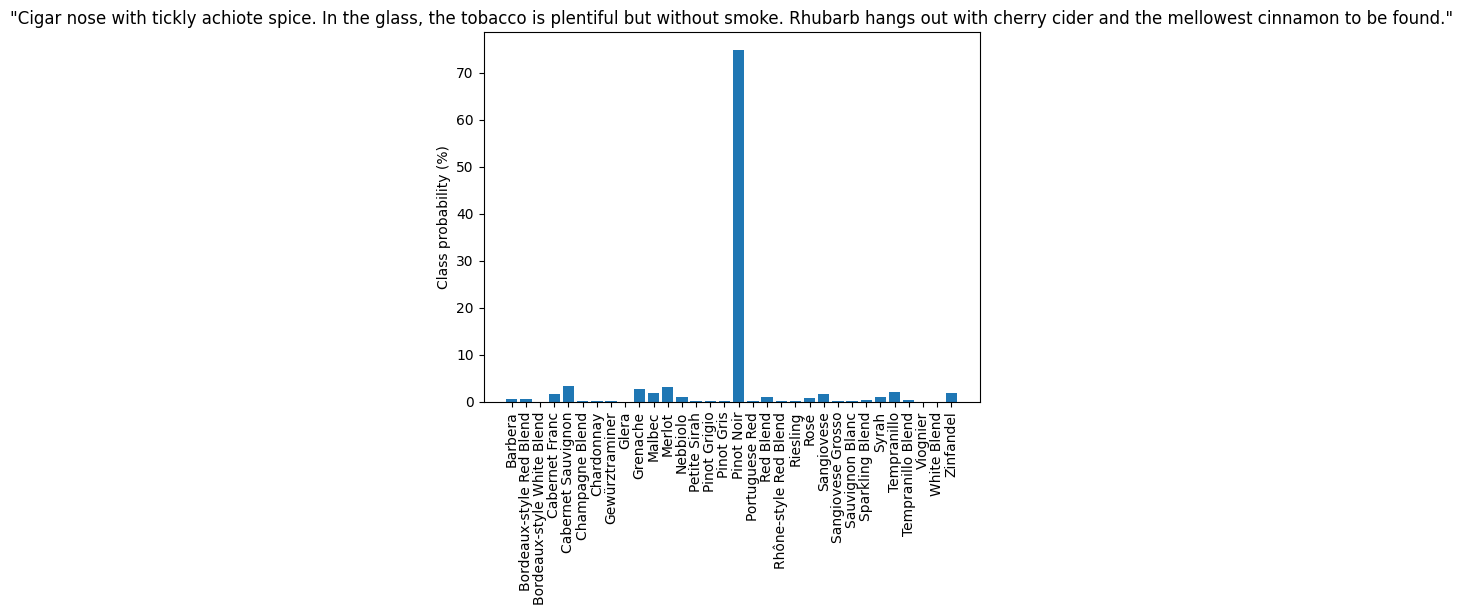

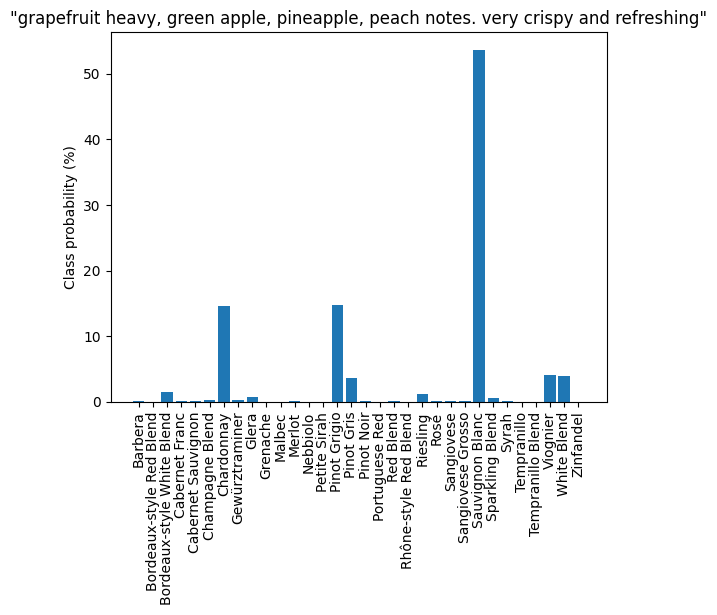

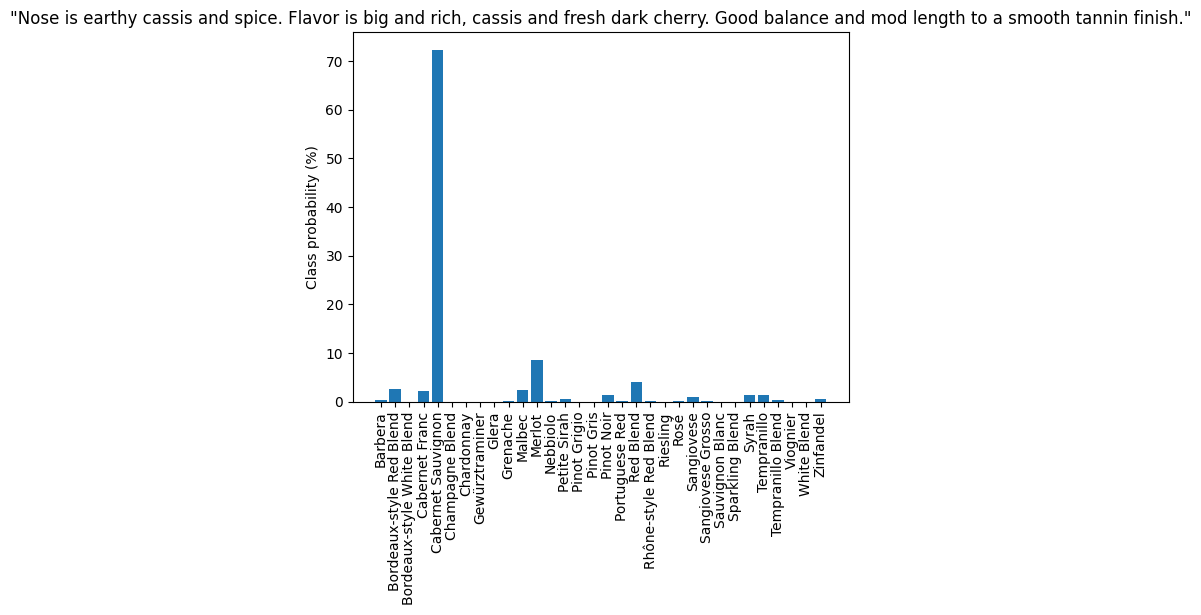

In [116]:
for i in range(len(wine_review)):
    preds_df = pd.DataFrame(preds[i])
    plt.bar(labels, 100 * preds_df["score"], color='C0')
    plt.xticks(rotation=90)
    plt.title(f'"{wine_review[i]}"')
    plt.ylabel("Class probability (%)")
    plt.show()

The model did surprising well. It got all the grape varieties correct and even though it wasn't as confident about the Sauvignon Blanc, it correctly put it ahead of a Pinot and Chardonnay by a significant margin!

## Conclusion and Future Improvements.

My hunch that I could build a useful wine classifier based on a corpus of wine reviews seems to be confirmed. Three epochs of training only required twenty minutes on a commodity desktop GPU but resulted in a respectable accuracy score of 0.73 compared to the performance of random chance of 0.14.

Even if we keep our self-imposed constrain of only using the review description an grape varieties for training, there are still plenty of improvements we can make. Here are a few obvious suggestions.

1. Review bias from the data sets. The heavy bias towards Pinot Grigio and a few other popular grapes is skewing our model.
2. Remove all labels from descriptions.
3. Increase the duration of training until the validation loss converges.
